In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Encoder
enc_input = Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(128, 5, padding='same', activation='relu')(enc_input)
x = Conv2D(64, 3, padding='same', strides=2, activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
enc_shape = tf.keras.backend.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Latent Space
latent_dim = 2  # 2D space
z_mean = Dense(latent_dim, name='Z_mean')(x)
z_logvar = Dense(latent_dim, name='Z_logvariance')(x)

def sampling(args):
    mean, logvar = args
    eps = tf.random.normal(shape=(tf.shape(mean)[0], latent_dim))
    rnd_sam = mean + tf.exp(logvar/2) * eps
    return rnd_sam

z = Lambda(sampling, output_shape=(latent_dim,), name='latent_space')([z_mean, z_logvar])
encoder = Model(enc_input, z, name='encoder')

# Decoder
dec_input = Input(shape=(latent_dim,), name='decoder_input')
true_shape = enc_shape[1:]
y = Dense(np.prod(true_shape), activation='relu')(dec_input)
y = Reshape(target_shape=true_shape)(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)
y = Conv2DTranspose(128, 5, padding='same', activation='relu')(y)
decoded = Conv2DTranspose(1, 5, padding='same', activation='sigmoid')(y)

decoder = Model(dec_input, decoded, name='decoder')

# VAE Model
vae_output = decoder(encoder(enc_input))
vae = Model(enc_input, vae_output, name='vae')

# Loss Function
reconstruction_loss_factor = 196
reconstruction_loss = MeanSquaredError()(tf.keras.backend.flatten(enc_input), tf.keras.backend.flatten(vae_output))
kl_loss = -0.5 * tf.reduce_sum(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss_factor * reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
opt = Adam(learning_rate=0.001)
vae.compile(optimizer=opt)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
history = vae.fit(x_train, x_train, epochs=10, batch_size=32, validation_data=(x_test, x_test), callbacks=[early_stopping])



Epoch 1/10
1875/1875 [==============================] - 34s 16ms/step - loss: 11.8873 - val_loss: 10.5810
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 10.4358 - val_loss: 10.5634
Epoch 3/10
1875/1875 [==============================] - 29s 16ms/step - loss: 10.2791 - val_loss: 10.2114
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 10.1963 - val_loss: 10.0941
Epoch 5/10
1875/1875 [==============================] - 29s 16ms/step - loss: 10.1301 - val_loss: 10.2644
Epoch 6/10
1875/1875 [==============================] - 29s 16ms/step - loss: 10.0918 - val_loss: 10.0574
Epoch 7/10
1875/1875 [==============================] - 29s 16ms/step - loss: 10.0670 - val_loss: 9.9957
Epoch 8/10
1875/1875 [==============================] - 29s 16ms/step - loss: 10.0334 - val_loss: 10.1094
Epoch 9/10
1875/1875 [==============================] - 30s 16ms/step - loss: 10.0040 - val_loss: 10.2167
Epoch 10/10
1875/1875 [========================

313/313 [==============================] - 1s 4ms/step


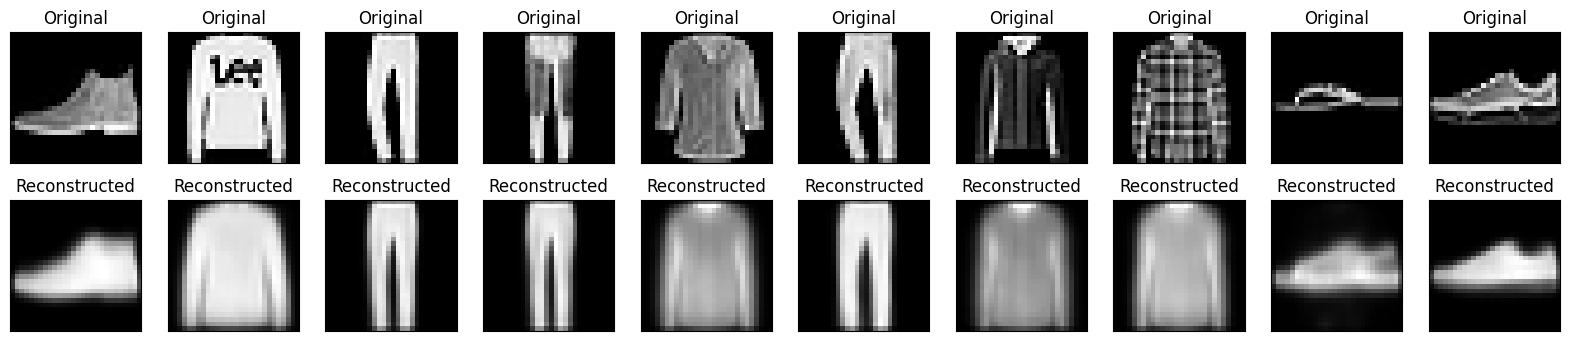

In [ ]:
# Visualize original and reconstructed images with labels
decoded_images = vae.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed")
plt.show()